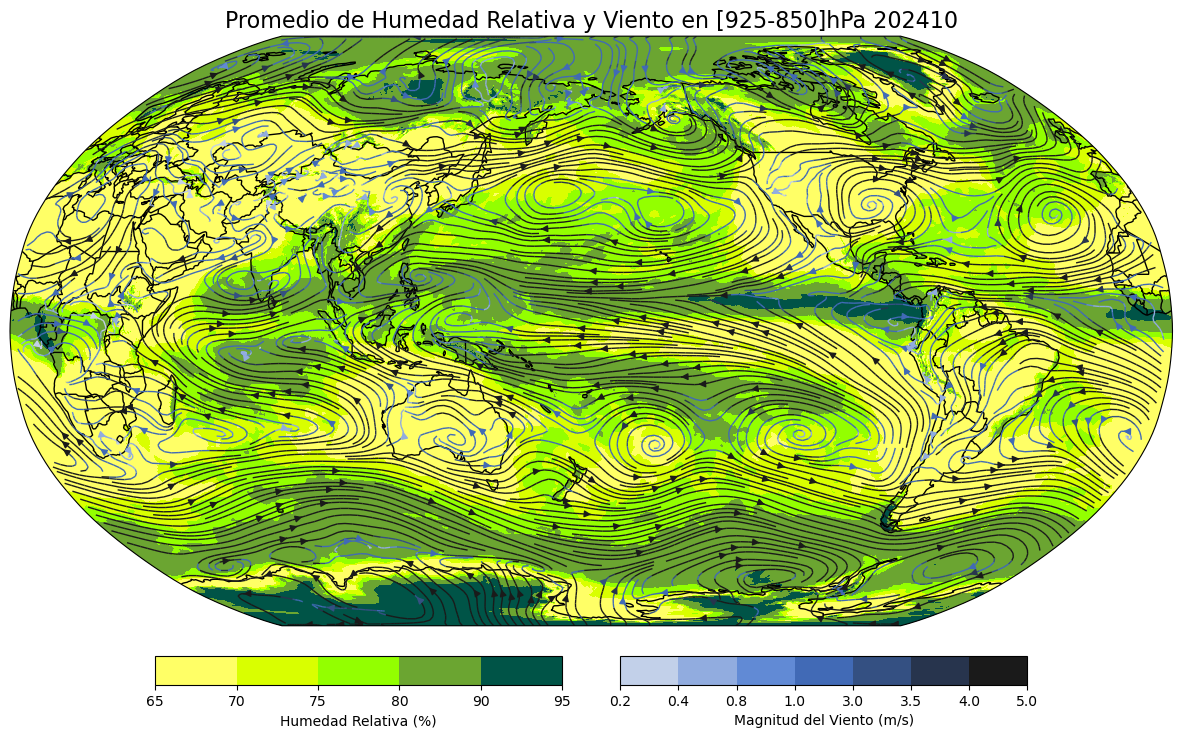

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import os

# Define la fecha inicial y la ruta del archivo GRIB
FECHA_INICIAL = 202410

# Función para convertir longitudes
def convert_longitudes(lon):
    return (lon + 180) % 360 - 180

# Cargar el archivo GRIB
ds = xr.open_dataset(f'/scratch/DMA/SMN/CLIMA/ERA5/NIVELES/pgb_era5_{FECHA_INICIAL}.grib', engine='cfgrib')

# Convertir las longitudes del dataset
ds['longitude'] = convert_longitudes(ds['longitude'])

# Asegurarse de que los niveles de 925 hPa y 850 hPa estén disponibles
levels_to_average = [925, 850]
if all(level in ds['isobaricInhPa'].values for level in levels_to_average):
    # Obtener el único tiempo disponible
    time = ds['time'].values
    # Formatear la fecha y el título
    fecha_actual = pd.to_datetime(str(time))
    mes_titulo = fecha_actual.strftime("%Y%m")
    
    # Crear el directorio de salida
    output_dir = f'/scratch/DMA/SMN/CLIMA/web_figuras/monitoreo/mensual'
    os.makedirs(output_dir, exist_ok=True)

    # Seleccionar las variables rh, u y v para los niveles de 925 hPa y 850 hPa
    rh_925 = ds['r'].sel(isobaricInhPa=925)
    rh_850 = ds['r'].sel(isobaricInhPa=850)
    u_925 = ds['u'].sel(isobaricInhPa=925)
    u_850 = ds['u'].sel(isobaricInhPa=850)
    v_925 = ds['v'].sel(isobaricInhPa=925)
    v_850 = ds['v'].sel(isobaricInhPa=850)

    # Calcular el promedio de rh, u y v entre 925 hPa y 850 hPa
    rh_avg = (rh_925 + rh_850) / 2
    u_avg = (u_925 + u_850) / 2
    v_avg = (v_925 + v_850) / 2

    # Coordenadas de longitud y latitud
    lon = ds['longitude']
    lat = ds['latitude']
    lon2d, lat2d = np.meshgrid(lon, lat)

    # Calcular la magnitud del viento
    wind_magnitude = np.sqrt(u_avg**2 + v_avg**2)

    # Crear una figura y un eje con una proyección Robinson y longitud central de 180 grados
    fig, ax = plt.subplots(figsize=(15, 11), subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})
    ax.set_global()

    # Definir los colores y valores para la humedad relativa
    rh_colors = ['#FFFF66', '#D9FF00', '#93FF00', '#6BA531', '#00724B', '#005447']  
    rh_values = [65, 70, 75, 80, 90, 95]

    rh_cmap = ListedColormap(rh_colors)
    rh_norm = BoundaryNorm(rh_values, len(rh_colors))

    # Graficar la humedad relativa usando pcolormesh
    rh_plot = ax.pcolormesh(lon, lat, rh_avg, transform=ccrs.PlateCarree(), cmap=rh_cmap, norm=rh_norm, shading='auto')

    # Añadir barra de color para la humedad relativa
    cax_q = inset_axes(ax, width="35%", height="4%", loc='lower center', bbox_to_anchor=(-0.2, -0.1, 1, 1.2), bbox_transform=ax.transAxes, borderpad=0)
    cbar_q = plt.colorbar(rh_plot, cax=cax_q, orientation='horizontal')
    cbar_q.set_label('Humedad Relativa (%)')
    cbar_q.set_ticks(rh_values)
   
    # Añadir características al mapa
    land_color = np.array([254, 227, 170]) / 255  # Convertir RGB a escala 0-1
    ax.add_feature(cfeature.LAND, facecolor=land_color)
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

    # Definir los colores y valores para las líneas de corriente
    wind_values = [0.2, 0.4, 0.8, 1, 3, 3.5, 4, 5]
    wind_norm = BoundaryNorm(wind_values, len(wind_values))
    wind_cmap = ListedColormap(['#C2D0E9', '#91ACDF', '#618AD5', '#416AB6', '#345082', '#27344D', '#1A1A1A'])

    # Trazar líneas de corriente con color según la magnitud del viento
    try:
        strm = ax.streamplot(lon2d, lat2d, u_avg.values, v_avg.values,
                             color=wind_magnitude.values, linewidth=1, cmap=wind_cmap, norm=wind_norm, density=5, transform=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error al trazar líneas de corriente: {e}")

    # Añadir barra de color para la magnitud del viento
    cax_wind = inset_axes(ax, width="35%", height="4%", loc='lower center', bbox_to_anchor=(0.2, -0.1, 1, 1.2), bbox_transform=ax.transAxes, borderpad=0)
    cbar_wind = plt.colorbar(strm.lines, cax=cax_wind, orientation='horizontal')
    cbar_wind.set_label('Magnitud del Viento (m/s)')

    # Mostrar la figura con el título actualizado
    ax.set_title(f'Promedio de Humedad Relativa y Viento en [925-850]hPa {mes_titulo}', fontsize=16)

    # Guardar la figura
    fig.savefig(f'{output_dir}/era5_{mes_titulo}_vientoHum850-925hpa_glob.png', dpi=300, bbox_inches='tight')
    # Muestra el gráfico
    plt.show()
    plt.close(fig)

else:
    print("Los niveles de 925 hPa y 850 hPa no están disponibles en el dataset.")
